# Initialisation

## Imports and General Functions

In [1]:
def IsNotebook():
    """Indicate the shell name, whether code is running on a notebook, and if so whether it's hosted on googlecolab."""
    isnotebook, isgooglecolab, shell = None, None, None
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            isnotebook, isgooglecolab = True, False   # Jupyter notebook or qtconsole
        elif shell == "Shell":
            isnotebook, isgooglecolab = True, True    # Google Colab
        elif shell == 'TerminalInteractiveShell':
            isnotebook, isgooglecolab = False, False  # Terminal running IPython
        else:
            isnotebook, isgooglecolab = False, False  # Other type (?)
    except NameError:
        isnotebook, isgooglecolab = False, False      # Probably standard Python interpreter
    return shell, isnotebook, isgooglecolab
shell, isnotebook, isgooglecolab = IsNotebook()
if isnotebook and not isgooglecolab: #If we are in a notebook but not on google colab, let's use all the available screen
    from IPython.display import display, HTML
    display(HTML("<style>.container { width:99% !important; }</style>"))
    if not isgooglecolab:
        try: #Using the jedi completer takes too long to complete words
            %config Completer.use_jedi = False
        except:
            pass
if isgooglecolab: #If we are in a google colab environment, we probably need to mount our google drive
    try:
        from google.colab import drive
        drive.mount('/content/drive')
    except Exception as e:
        print(e)

In [2]:
#######################
### General Imports ###
import os #Making sure we're using all CPU cores for faster calculations
IsWindows = os.name == 'nt'
os.environ["OMP_NUM_THREADS"] = str(os.cpu_count())
os.environ["OPENBLAS_NUM_THREADS"] = str(os.cpu_count())
os.environ["MKL_NUM_THREADS"] = str(os.cpu_count())
os.environ["VECLIB_MAXIMUM_THREADS"] = str(os.cpu_count())
os.environ["NUMEXPR_NUM_THREADS"] = str(os.cpu_count())

import sys #Printing version for posterity
print("Python version:", sys.version)

try: #Allows saving and loading of variables
    import pickle5 as pickle
except:
    import pickle
try: #Printing version for posterity
    print("Pickle version:", pickle.__version__)
except:
    print("Pickle version:", pickle.format_version)
    
import dill as dill #Allows even deeper saving (associated classes, etc., as well)
print("Dill version:", dill.__version__)

import warnings #Ability to create custom warnings, like warnings.warn("deprecated", DeprecationWarning)
import itertools #Needed for Confusion Matrix

from collections import Counter #Allows for frequency counting similar with R's "table"
#######################


#####################
### Date and Time ###
import time #Gets the current time
from pytz import timezone #Allows for timezones to be set. #pytz.all_timezones
from datetime import datetime #Allows for Datetime objects like current Datetime. #datetime.fromisoformat('2021-05-24')
#There's also: np.datetime64('2021-08-01')
#####################


###################
### Mathematics ###
import numpy as np #Working with numeric arrays
print("Numpy version:", np.__version__)
###################


#######################################
### Statistics and Machine Learning ###
#Utility
from sklearn.preprocessing import StandardScaler #Various ways of scaling the data
from sklearn.model_selection import train_test_split

#Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

#Machine Learning
from sklearn.ensemble import RandomForestClassifier
#######################################


##################
### Dataframes ###
import pandas as pd
##################


#############
### Plots ###
import matplotlib.pyplot as plt #Allows use of Pyplot plots

import seaborn as sns #Allows use of Seaborn plots
sns.set() #Sets default plot theme
#############


###################################
### Files, Directories, Folders ###
from pathlib import Path
###################################


########################
### Useful functions ###
if "OrigFigSize" not in locals() and "OrigFigSize" not in globals(): #Just in case Initialisation is re-run after any of these have chaned
    OrigFigSize   = plt.rcParams["figure.figsize"]

NonNans = lambda List: List[np.logical_not(np.isnan(List))]
LastNonNan = lambda List: NonNans(List)[-1] if np.sum(np.isnan(List)) < len(List) else np.array([]) if type(List) == np.ndarray else []

def SpaceAString(CurString, MaxLength, SpaceTheFront = True, ForceMaxLength = False, ForceRemoveFromFront = False):
    """Prepend/Append (SpaceTheFront) spaces to CurString until it meets ForceMaxLength or if ForceMaxLength also Clip characters from the beginning/end (ForceRemoveFromFront) until it meets ForceMaxLength."""
    CurLen = len(CurString)
    Result = CurString
    
    if CurLen < MaxLength:
        if SpaceTheFront:
            Result = (" " * (MaxLength-CurLen)) + CurString
        else:
            Result = CurString + (" " * (MaxLength-CurLen))
    elif CurLen > MaxLength and ForceMaxLength:
        if ForceRemoveFromFront:
            Result = CurString[(CurLen - MaxLength):]
        else:
            Result = CurString[:-(CurLen - MaxLength)]
    return Result

def WriteText(TextParsableVar, FullFilePath):
    """Take a string (or string-parsable variable) and save it as text file on the directory and with a name indicated by FullFilePath."""
    try:
        DirName = Path(FullFilePath).parent.absolute()
        os.makedirs(DirName, exist_ok = True)
        
        FileOptions = open(FullFilePath, "w")
        FileOptions.writelines(
            f"{TextParsableVar}"
        )
    except Exception as e:
        print(f"Exception:\n{e}")
    finally:
        try:
            FileOptions.close()
        except Exception:
            pass
SaveText = lambda TextParsableVar, FullFilePath: WriteText(TextParsableVar, FullFilePath) #Alias for WriteText to be the same as Save/Load Variable

def ReadText(FullFilePath):
    """Read the string content of a text file given by FullFilePath and return it as a string."""
    with open(FullFilePath, "r+", encoding = "utf8") as io:
        TextString = io.read()
    return TextString
LoadText = lambda FullFilePath: ReadText(FullFilePath) #Alias for ReadText to be the same as Save/Load Variable

def SaveVariable(Variable, FileName):
    """Create the directory path for and pickle Variable under FileName."""
    DirName = Path(FileName).parent.absolute()
    os.makedirs(DirName, exist_ok = True)
    with open(FileName, 'wb') as io:
        pickle.dump(Variable, io)

def SaveVariableDill(Variable, FileName):
    """Create the directory path for and deep-save Variable under FileName using dill."""
    DirName = Path(FileName).parent.absolute()
    os.makedirs(DirName, exist_ok = True)
    with open(FileName, 'wb') as io:
        dill.dump(Variable, io)
    
def LoadVariable(FileName):
    """Un-pickle a binary file saved under FileName and return it as a variable."""
    with open(FileName, "rb") as io:
        Res = pickle.load(io)
    return Res

def LoadVariableDill(FileName):
    """Read the content of a binary file saved under FileName and return it as a variable."""
    with open(FileName, 'rb') as io:
        Res = dill.load(io)
    return Res
########################

Python version: 3.8.13 (default, Mar 28 2022, 06:59:08) [MSC v.1916 64 bit (AMD64)]
Pickle version: 4.0
Dill version: 0.3.4
Numpy version: 1.21.5

PyTorch v1.11.0
CUDA device available: True
1 devices available
	NVIDIA GeForce RTX 2080 SUPER
cuda: 0
Num threads set to: 48
device= cuda


## Dataset Functions

In [3]:
def train_valid_test_split(X_Data, train_size, valid_size, Y_Data = None, random_state = None, shuffle = True, stratify = None):
    """Split the dataset, optionally in a stratified manner, into a Train, Validation and Test set"""
    
    if (type(train_size) == int and sum([train_size, valid_size]) >= len(X_Data)) or (type(train_size) != int and sum([train_size, valid_size]) >= 1):
        raise ValueError(f"The train_size [{train_size}] + the valid_size [{valid_size}] should sum up to less than 100% so that there's some percentage left for the test set")
    
    TrainIdx, ValidTestIdx = train_test_split(np.arange(len(X_Data)), train_size = train_size, shuffle = shuffle, stratify = stratify, random_state = random_state)
    TrainX     = X_Data[TrainIdx]
    ValidTestX = X_Data[ValidTestIdx]
    if Y_Data is not None:
        TrainY     = Y_Data[TrainIdx]
        ValidTestY = Y_Data[ValidTestIdx]
    
    if type(train_size) != int: #For the 2nd split we need the validation percent relative to the Valid/Test portion of the dataset alone
        test_size  = 1 - train_size - valid_size #Actual test size
        valid_size = 1 - (test_size / (valid_size + test_size)) #Relative (to ValidTest) valid size
        test_size  = 1 - valid_size #Relative (to ValidTest) test size
    
    if Y_Data is not None:
        ValidX, TestX, ValidY, TestY = train_test_split(ValidTestX, ValidTestY, train_size = valid_size, shuffle = shuffle, stratify = stratify[ValidTestIdx] if stratify is not None else None, random_state = random_state)
        return TrainX, ValidX, TestX, TrainY, ValidY, TestY
    else:
        ValidX, TestX = train_test_split(ValidTestX, train_size = valid_size, shuffle = shuffle, stratify = stratify[ValidTestIdx] if stratify is not None else None, random_state = random_state)
        return TrainX, ValidX, TestX

In [4]:
def Scale(x_data, scaler_mean, scaler_sd, verbose = True):
    """Scale a Torch Tensor or Numpy Array to have zero mean and unit variance."""
    if isinstance(x_data, torch.Tensor):
        if (isinstance(scaler_mean, np.number) or isinstance(scaler_sd, np.number)) and x_data.shape[1] != 1:
            if verbose:
                print("Info: Scaler is a scalar but X's observations are not. Safely ignore this if you intended to normalise with scalar parameters.")
            return ((x_data - scaler_mean) / scaler_sd).float()
        else:
            return ((x_data - torch.from_numpy(scaler_mean)) / torch.from_numpy(scaler_sd)).float()
    elif isinstance(x_data, np.ndarray):
        if verbose and (isinstance(scaler_mean, np.number) or isinstance(scaler_sd, np.number)) and x_data.shape[1] != 1:
            print("Info: Scaler is a scalar but X's observations are not. Safely ignore this if you intended to normalise with scalar parameters.")
        return ((x_data - scaler_mean) / scaler_sd).astype(np.float32)
    else:
        raise Exception("Cannot scale the variable because it is neither a Torch Tensor nor a Numpy Array")
        return None

def UnScale(x_data, scaler_mean, scaler_sd, verbose = True):
    """Inverse the scaling of a Torch Tensor or Numpy Array that currently have zero mean and unit variance."""
    if isinstance(x_data, torch.Tensor):
        if (isinstance(scaler_mean, np.number) or isinstance(scaler_sd, np.number)) and x_data.shape[1] != 1:
            if verbose:
                print("Info: Scaler is a scalar but X's observations are not. Safely ignore this if you intended to normalise with scalar parameters.")
            return ((x_data * scaler_sd) + scaler_mean).float()
        else:
            return ((x_data * torch.from_numpy(scaler_sd)) + torch.from_numpy(scaler_mean)).float()
    elif isinstance(x_data, np.ndarray):
        if verbose and (isinstance(scaler_mean, np.number) or isinstance(scaler_sd, np.number)) and x_data.shape[1] != 1:
            print("Info: Scaler is a scalar but X's observations are not. Safely ignore this if you intended to normalise with scalar parameters.")
        return ((x_data * scaler_sd) + scaler_mean).astype(np.float32)
    else:
        raise Exception("Cannot unscale the variable because it is neither a Torch Tensor nor a Numpy Array")
        return None

## Optimisation Functions

In [5]:
def ClassAccMulti(Targets, Preds, K):
    """Calculate the Class-Wise accuracy for a multi-class task"""
    return(np.mean([(Targets == k) == (Preds == k) for k in range(K)]))

In [6]:
def AccCalculation(Y_Hat, Targets):    
    """Calculate the Accuracy given the Actual values and Predictions for Binary and Multiclass Classification."""
    if isinstance(Targets, torch.Tensor):
        Targets = Targets.cpu().numpy()
    
    if isinstance(Y_Hat, torch.Tensor):
        Y_Hat = Y_Hat.cpu().numpy()
        
    return np.mean(Y_Hat == Targets)

In [7]:
def AUCCalculation(Targets, Y_Prob, Y_Hat, Verbose = True):
    """Calculate the Area Under the Receiver Operating Characteristic Curve given the Actual values and Predictions for Binary and Multiclass Classification using sklearn's roc_auc_score()."""
    if isinstance(Targets, torch.Tensor):
        Targets = Targets.cpu().numpy()
    
    if isinstance(Y_Prob, torch.Tensor):
        Y_Prob = Y_Prob.cpu().numpy()
    
    if isinstance(Y_Hat, torch.Tensor):
        Y_Hat = Y_Hat.cpu().numpy()
    
    try:
        CurMetric2 = roc_auc_score(Targets, Y_Prob, multi_class = "ovr", average = 'weighted') #Calculating Weighted AUC #Cares for performance both in Positives and Negatives (but may not fare well with heavy class imbalance)
    except Exception as exc:
        CurMetric2 = np.nan
        if Verbose:
            warnings.warn(f"\nAn error occurred in AUC calculation (probably because of missing classes in the random batch of data?).\nThe error reads: {exc}")
            print("AUC Warning. set(Targets):", list(set(Targets.reshape(-1))), "set(Outputs): ", list(set(Y_Hat.reshape(-1))))
            
    return CurMetric2

In [8]:
def F1ScoreCalculation(Targets, Y_Hat):
    """Calculate the F1 score given the Actual values and Predictions for Binary and Multiclass Classification using sklearn's f1_score()."""
    if isinstance(Targets, torch.Tensor):
        Targets = Targets.cpu().numpy()
    
    if isinstance(Y_Hat, torch.Tensor):
        Y_Hat = Y_Hat.cpu().numpy()
    
    try:
        CurMetric3 = f1_score(Targets, Y_Hat, average = 'weighted') #Calculating Weighted F1 #Cares about balance between Precision and Recall (Sensitivity)
    except Exception as exc:
        CurMetric3 = np.nan
        warnings.warn(f"\nAn error occurred in F1 score calculation (probably because of missing classes in the random batch of data?).\nThe error reads: {exc}")
            
    return CurMetric3

## Evaluation Functions

In [9]:
def plot_confusion_matrix(cm, classes, normalise = False, title = 'Confusion matrix', colourmap = plt.cm.Blues):
    """Plot the Confusion Matrix object returned by sklearn's confusion_matrix() and normalise it if normalise==True."""
    plt.grid(False)
    if normalise:
        print('Confusion matrix')
        print(cm)
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        plt.imshow(cm, interpolation = 'nearest', cmap = colourmap)
        plt.clim(0.0, 1.0)
    else:
        plt.imshow(cm, interpolation = 'nearest', cmap = colourmap)
    plt.title(title)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalise else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [10]:
def GetCategoricalMetrics(Y_Prob, Y_Hat, Targets, Verbose = True):
    """Calculate Categorical variable metrics (Accuracy, Area Under the Curve, F1 score) given the class Probability vector (binary) / matrix (multiclass), the class index (0 to K-1), and the Actual values."""
    test_Acc = AccCalculation(Y_Hat, Targets)
    test_AUC = AUCCalculation(Targets, Y_Prob, Y_Hat, Verbose = Verbose)
    test_F1 = F1ScoreCalculation(Targets, Y_Hat)
    
    return test_Acc, test_AUC, test_F1

In [11]:
def PlotCategoricalMetrics(Y_Hat, Targets, ClassNames, normalise, figsize = None):
    """Plots the Confusion matrix given the class index (0 to K-1), and the Actual values."""
    PrevFigSize = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = figsize if figsize is not None else PrevFigSize
    
    cm = confusion_matrix(Targets, Y_Hat)
    plot_confusion_matrix(cm, ClassNames, normalise = normalise)
    
    plt.rcParams['figure.figsize'] = PrevFigSize

# Data

In [12]:
#Configuring the basic structure of our current directory
path_root = f"{os.getcwd()}"
path_data = f"{Path(path_root).absolute()}/Data"
path_models = f"{path_root}/Models"
print(path_root)
print(path_data)
print(path_models)

D:\GiannisM\Downloads\Exercises\Fiver\100. frotribe FFNN Multiclass Classification
D:\GiannisM\Downloads\Exercises\Fiver\100. frotribe FFNN Multiclass Classification/Data
D:\GiannisM\Downloads\Exercises\Fiver\100. frotribe FFNN Multiclass Classification/Models


,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200
0,1,0.147911,0.133120,0.025052,-0.070056,-0.060896,-0.121567,-0.098642,-0.011251,-0.005818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.096198,-0.066323,-0.180289,-0.175182,-0.108132,-0.080090,0.250950,-0.125172,0.287903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,-0.500452,-0.502092,-0.475572,-0.425861,-0.389736,-0.402447,-0.495722,-0.568901,-0.576617,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,-0.307718,-0.320017,-0.344007,-0.309607,-0.289414,-0.333693,-0.414461,-0.556066,-0.711506,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,-0.103104,-0.148786,-0.189899,-0.093382,0.025787,0.158881,0.220521,0.142476,0.063623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,8,-0.064396,-0.178618,-0.246944,-0.049874,0.179200,0.079402,0.045606,0.273751,0.224829,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4831,8,0.117115,0.049382,0.134941,0.065425,0.011479,0.212872,0.394126,0.320238,0.258048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4832,8,0.213987,0.145185,0.117739,0.140440,0.290152,0.308540,0.079455,0.088747,0.010922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4833,8,0.088052,0.105103,-0.000214,0.090305,0.115749,0.151577,0.101945,0.152081,-0.005337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


X_Data.shape : (4835, 1200) min: -40.75 max: 49.11 Y_Data.shape : (4835,)
X_Train.shape: (3868, 1200) min: -48.25 max: 51.08 Y_Train.shape: (3868,)
X_Valid.shape: (483, 1200) min: -54.38 max: 36.09 Y_Valid.shape: (483,)
X_Test.shape : (484, 1200) min: -26.58 max: 37.10 Y_Test.shape : (484,)
K_Length: 8
N: 3868 H1: 1 W1: 1 D_Length: 1200

Classes:


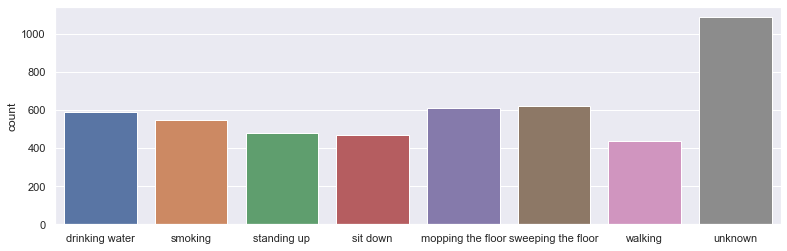

0: 12.18% [  589]
1: 11.35% [  549]
2:  9.87% [  477]
3:  9.64% [  466]
4: 12.57% [  608]
5: 12.86% [  622]
6:  9.06% [  438]
7: 22.46% [ 1086]

Classes [TRAIN]:


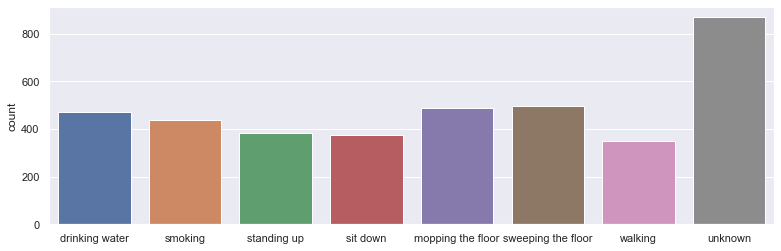


Classes [Valid]:


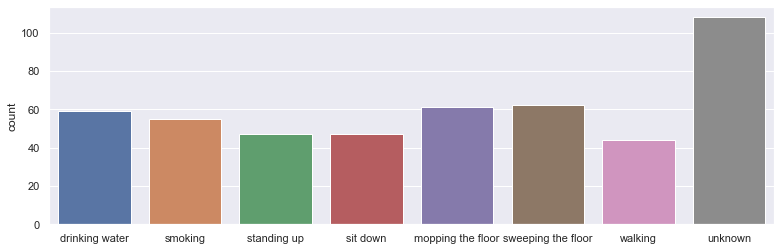


Classes [Test ]:


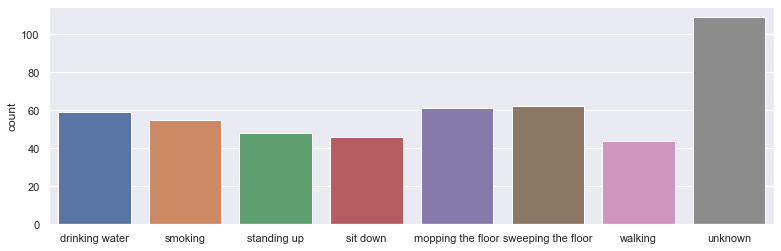

0: Train 12.18% [  471], Valid 12.22% [   59], Test 12.19% [   59]
1: Train 11.35% [  439], Valid 11.39% [   55], Test 11.36% [   55]
2: Train  9.88% [  382], Valid  9.73% [   47], Test  9.92% [   48]
3: Train  9.64% [  373], Valid  9.73% [   47], Test  9.50% [   46]
4: Train 12.56% [  486], Valid 12.63% [   61], Test 12.60% [   61]
5: Train 12.87% [  498], Valid 12.84% [   62], Test 12.81% [   62]
6: Train  9.05% [  350], Valid  9.11% [   44], Test  9.09% [   44]
7: Train 22.47% [  869], Valid 22.36% [  108], Test 22.52% [  109]

Done


In [14]:
############################
## Data Hyperparameters ####
Seed           = 42
batch_size     = 256
TrainPerc      = 0.8
ValidPerc      = 0.1
TestPerc       = 1 - TrainPerc - ValidPerc
CustomNAString = None
#############################

########################
### Reading the Data ###
Classes = ['drinking water', 'smoking', 'standing up', 'sit down', 'mopping the floor', 'sweeping the floor', 'walking', 'unknown']
XY_DF = pd.read_csv(f"{path_data}/11-16 (1).csv", header = None)
display(XY_DF) if isnotebook else print(XY_DF)
########################

####################
### Handling NAs ###
NBeforeCustomNADrop = None
DroppedCustomNARows = None
NBeforeNADrop = len(XY_DF)
XY_DF = XY_DF.dropna()
DroppedNARows = NBeforeNADrop - len(XY_DF)
if DroppedNARows > 0:
    print(f"Dropped NA rows count: {DroppedNARows} (out of {NBeforeNADrop})")

if CustomNAString is not None:
    NBeforeCustomNADrop = len(XY_DF)
    XY_DF = XY_DF.replace(CustomNAString, np.nan, regex = False).dropna()
    DroppedCustomNARows = NBeforeCustomNADrop - len(XY_DF)
    if DroppedCustomNARows > 0:
        print(f"Dropped custom NA rows count: {DroppedCustomNARows} (out of {NBeforeCustomNADrop})", )
if DroppedNARows > 0 or (DroppedCustomNARows is not None and DroppedCustomNARows > 0):
    print()
####################

######################################
### Creating Train/Valid/Test sets ###
X_Data = XY_DF.iloc[:, 1:].values.astype(np.float32)
Y_Data = XY_DF.iloc[:, 0 ].values.astype(int).squeeze() - 1

Labels_Data  = np.array([Classes[y] for y in Y_Data])

#==Stratified Split
TrainIndx, ValidIndx, TestIndx = train_valid_test_split(np.arange(X_Data.shape[0]), train_size = TrainPerc, valid_size = ValidPerc, Y_Data = None, random_state = Seed, shuffle = True, stratify = Y_Data)
X_Train      =      X_Data[TrainIndx]
Y_Train      =      Y_Data[TrainIndx]
Labels_Train = Labels_Data[TrainIndx]
X_Valid      =      X_Data[ValidIndx]
Y_Valid      =      Y_Data[ValidIndx]
Labels_Valid = Labels_Data[ValidIndx]
X_Test       =      X_Data[TestIndx ]
Y_Test       =      Y_Data[TestIndx ]
Labels_Test  = Labels_Data[TestIndx ]
######################################

########################
### Scaling the Data ###
# scaler = LoadVariable(f"{SaveFolder}/scaler") #After loading a model with a different scaler we need to re-run this using the newly loaded scaler.
# print("\n\n\n!!!!!!!!!!!!\nDEBUGGING:\nScaling with SaveFolder scaler!!!\n!!!!!!!!!!!!\n\n\n")

# if os.path.exists(f"{path_models}/scaler"):
#     print("!!\n!! Using saved scaler.\n!!\n")
#     scaler = LoadVariable(f"{path_models}/scaler")
# else:
scaler = StandardScaler(with_mean = True, with_std = True).fit(X_Train)
SaveVariable(scaler, f"{path_models}/scaler")

scaler_mean = scaler.mean_
scaler_sd = scaler.scale_
scaler_mean_sd = (scaler_mean, scaler_sd)

#Numpy takes care of the broadcasting automatically
X_Train      = Scale(X_Train, *scaler_mean_sd)
X_Valid      = Scale(X_Valid, *scaler_mean_sd)
X_Test       = Scale(X_Test , *scaler_mean_sd)
########################

##############################
### Extracting Information ###
K_Length, O_Length, N, D_Length, H1, W1 = len(set(Y_Train.squeeze().tolist())), 1, len(Y_Train), X_Data.shape[1], 1, 1
print(f"X_Data.shape : {(len(X_Data ), *X_Data.shape[1:])} min: {X_Data.min():.2f} max: {X_Data.max():.2f} Y_Data.shape : {Y_Data.shape }")
print(f"X_Train.shape: {(len(X_Train), *X_Data.shape[1:])} min: {X_Train.min():.2f} max: {X_Train.max():.2f} Y_Train.shape: {Y_Train.shape}")
print(f"X_Valid.shape: {(len(X_Valid), *X_Data.shape[1:])} min: {X_Valid.min():.2f} max: {X_Valid.max():.2f} Y_Valid.shape: {Y_Valid.shape}")
print(f"X_Test.shape : {(len(X_Test ), *X_Data.shape[1:])} min: {X_Test.min():.2f} max: {X_Test.max():.2f} Y_Test.shape : {Y_Test.shape }")
print(f"K_Length: {K_Length}")
print(f"N: {N} H1: {H1} W1: {W1} D_Length: {D_Length}")

plt.rcParams['figure.figsize'] = [13, 4]
print(f"\nClasses:")
sns.countplot(x = [Classes[int(y)] for y in sorted(Y_Data.squeeze())])
plt.show()

CountData = sorted(Counter(Y_Data.squeeze()).items())
FreqKeys = [kv[0] for kv in CountData]
FreqData = np.array([kv[1] for kv in CountData]) / len(Y_Data) * 100
for i in range(len(FreqData)):
    print(f"{FreqKeys[i]}: {SpaceAString(f'{FreqData[i]:.2f}', MaxLength = 5)}% [{SpaceAString(f'{CountData[i][1]}', MaxLength = 5)}]")

print(f"\nClasses [TRAIN]:")
sns.countplot(x = [Classes[int(y)] for y in sorted(Y_Train.squeeze())])
plt.show()

print(f"\nClasses [Valid]:")
sns.countplot(x = [Classes[int(y)] for y in sorted(Y_Valid.squeeze())])
plt.show()

print(f"\nClasses [Test ]:")
sns.countplot(x = [Classes[int(y)] for y in sorted(Y_Test.squeeze() )])
plt.show()
plt.rcParams['figure.figsize'] = OrigFigSize

CountTrain = sorted(Counter(Y_Train.squeeze()).items())
FreqTrain  = np.array([kv[1] for kv in CountTrain]) / len(Y_Train) * 100
CountValid = sorted(Counter(Y_Valid.squeeze()).items())
FreqValid  = np.array([kv[1] for kv in CountValid]) / len(Y_Valid) * 100
CountTest  = sorted(Counter(Y_Test.squeeze()).items())
FreqTest   = np.array([kv[1] for kv in CountTest ]) / len(Y_Test ) * 100

for i in range(len(FreqKeys)):
    print(f"{FreqKeys[i]}: Train {SpaceAString(f'{FreqTrain[i]:.2f}', MaxLength = 5)}% [{SpaceAString(f'{CountTrain[i][1]}', MaxLength = 5)}], Valid {SpaceAString(f'{FreqValid[i]:.2f}', MaxLength = 5)}% [{SpaceAString(f'{CountValid[i][1]}', MaxLength = 5)}], Test {SpaceAString(f'{FreqTest[i]:.2f}', MaxLength = 5)}% [{SpaceAString(f'{CountTest[i][1]}', MaxLength = 5)}]")
##############################

print("\nDone")

# Random Forest

## Hyper Parameters

In [126]:
#Regular
conv_input_size = X_Train[0].shape if X_Train is not None else X_Data[0].shape
input_size = np.prod(conv_input_size)
output_size = np.prod(O_Length)
print("conv_input_size: " + str(conv_input_size) + ", input_size: " + str(input_size) + ", D_Length: " + str(D_Length) + ", output_size: " + str(output_size))
###
criterion = 'gini' #'gini' 'entropy' 'log_loss'
class_weight = "balanced" #We have an Imbalanced dataset, so lets balance the weights
min_impurity_decrease = 1e-6
max_leaf_nodes = None
max_features = int(np.round(np.sqrt(D_Length)))
min_weight_fraction_leaf = 1e-4
min_samples_leaf = 1
min_samples_split = 2
max_depth = 50

conv_input_size: (1200,), input_size: 1200, D_Length: 1200, output_size: 1


## Model

In [127]:
start_time = time.time() #To calculate the duration of the whole learning procedure

model = RandomForestClassifier(
    criterion                = criterion,
    max_depth                = max_depth,
    min_samples_split        = min_samples_split, #Min number of samples required to split an internal node
    min_samples_leaf         = min_samples_leaf, #Min number of samples required to be at a leaf node
    min_weight_fraction_leaf = min_weight_fraction_leaf, #Min weighted fraction of the sum total of weights required at a leaf
    max_features             = max_features, #Maximum variable to consider for best split
    max_leaf_nodes           = max_leaf_nodes, #Grow trees with max_leaf_nodes in best-first fashion
    min_impurity_decrease    = min_impurity_decrease,
    bootstrap                = True,
    oob_score                = False, # use out-of-bag samples to estimate the generalization score
    n_jobs                   = None if IsWindows else os.cpu_count(),
    random_state             = Seed,
    verbose                  = 0,
    warm_start               = False, #Continue from previous training with new independent variables
    class_weight             = None,
    ccp_alpha                = 0.0,
    max_samples              = None #Number of samples to draw for each base estimator
)
model.fit(X_Train, Y_Train)

elapsed_time = time.time() - start_time

Y_Prob_Train = model.predict_proba(X_Train)
Y_Hat_Train  = model.predict(X_Train)
Y_Prob_Valid = model.predict_proba(X_Valid)
Y_Hat_Valid  = model.predict(X_Valid)

train_Acc, train_AUC, train_F1 = GetCategoricalMetrics(Y_Prob_Train, Y_Hat_Train, Y_Train, Verbose = True)
valid_Acc, valid_AUC, valid_F1 = GetCategoricalMetrics(Y_Prob_Valid, Y_Hat_Valid, Y_Valid, Verbose = True)

print(f'Train Acc: {train_Acc:.2f} AUC: {train_AUC:.2f} F1: {train_F1:.2f}, Valid Acc: {valid_Acc:.2f} AUC: {valid_AUC:.2f} F1: {valid_F1:.2f}')
FinishedOn = datetime.now(datetime.now().astimezone().tzinfo).strftime("%a, %Y-%m-%d %H:%M %Z %z")
print("Done (" + FinishedOn + ") Elapsed time: " + str(round(elapsed_time, 1)) + " seconds")

Train Acc: 1.00 AUC: 1.00 F1: 1.00, Valid Acc: 0.91 AUC: 0.99 F1: 0.91
Done (Tue, 2022-09-13 11:22 GTB Summer Time +0300) Elapsed time: 2.6 seconds


# Evaluation

Sample-wise Acc: 93.60%, AUC: 0.99, F1: 0.94
Class-wise  Acc: 98.40%, Recall: 0.936, Precision: 0.937

Confusion matrix
[[ 56   3   0   0   0   0   0   0]
 [  1  54   0   0   0   0   0   0]
 [  0   0  48   0   0   0   0   0]
 [  0   0   0  46   0   0   0   0]
 [  0   0   0   2  54   4   0   1]
 [  0   0   0   0   9  51   2   0]
 [  0   0   1   0   3   0  37   3]
 [  2   0   0   0   0   0   0 107]]


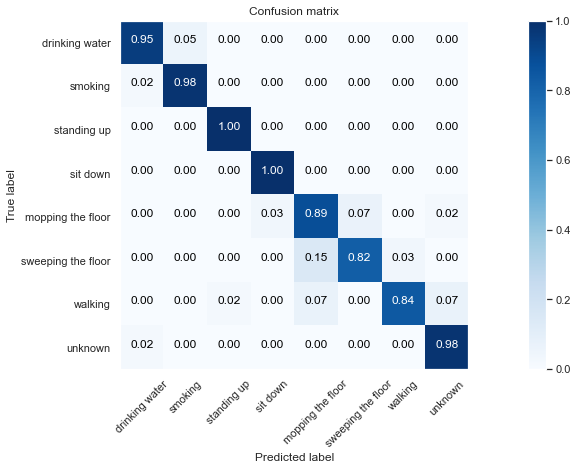


Class drinking water. Sample-Wise Acc: 0.988, Recall: 0.949, Precision: 0.949, F1: 0.949


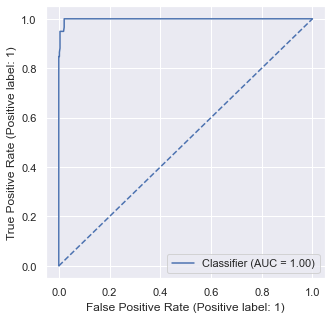


Class smoking. Sample-Wise Acc: 0.992, Recall: 0.982, Precision: 0.947, F1: 0.964


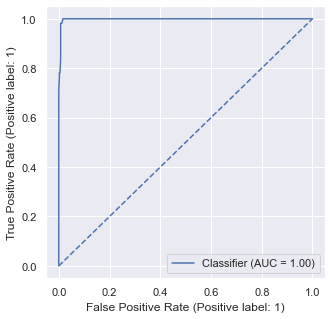


Class standing up. Sample-Wise Acc: 0.998, Recall: 1.000, Precision: 0.980, F1: 0.990


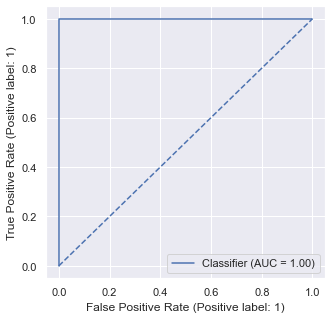


Class sit down. Sample-Wise Acc: 0.996, Recall: 1.000, Precision: 0.958, F1: 0.979


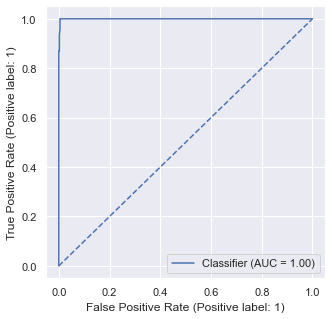


Class mopping the floor. Sample-Wise Acc: 0.961, Recall: 0.885, Precision: 0.818, F1: 0.850


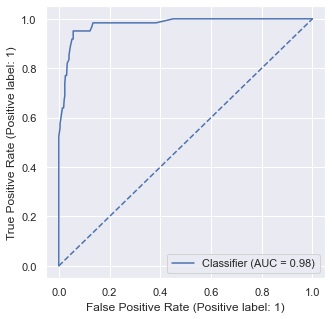


Class sweeping the floor. Sample-Wise Acc: 0.969, Recall: 0.823, Precision: 0.927, F1: 0.872


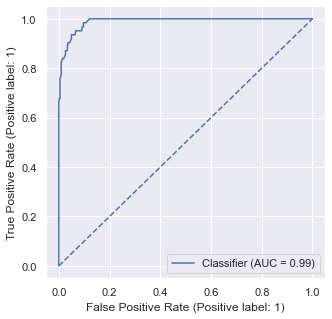


Class walking. Sample-Wise Acc: 0.981, Recall: 0.841, Precision: 0.949, F1: 0.892


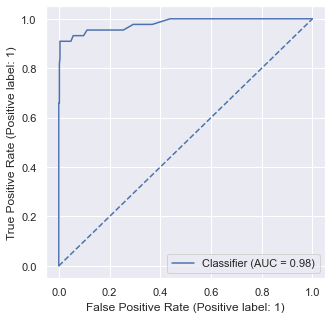


Class unknown. Sample-Wise Acc: 0.988, Recall: 0.982, Precision: 0.964, F1: 0.973


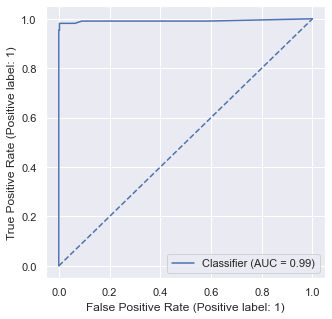

In [128]:
Labels = Classes
Preds_prob, Preds, Targets = model.predict_proba(X_Test), model.predict(X_Test), Y_Test

test_Acc, test_AUC, test_F1 = GetCategoricalMetrics(Preds_prob, Preds, Targets)
print(f'Sample-wise Acc: {test_Acc * 100:.2f}%, AUC: {test_AUC:.2f}, F1: {test_F1:.2f}')
print(f"Class-wise  Acc: {ClassAccMulti(Targets, Preds, K_Length) * 100:.2f}%, Recall: {recall_score(Targets, Preds, average = 'weighted'):.3f}, Precision: {precision_score(Targets, Preds, average = 'weighted'):.3f}\n") #'micro', 'macro', 'weighted', 'samples'

#Viewing the overall Categorical metrics and Plotting the Confusion Matrix
PlotCategoricalMetrics(Preds, Targets, Labels, normalise = True, figsize = [17, 6.5])
print("")

PrevFigSize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [5, 5]
for k in range(K_Length):
    PredClass = Preds   == k
    TrueClass = Targets == k
    print(f"Class {Classes[k]}. Sample-Wise Acc: {np.mean(TrueClass == PredClass):.3f}, Recall: {recall_score(TrueClass, PredClass):.3f}, Precision: {precision_score(TrueClass, PredClass):.3f}, F1: {f1_score(TrueClass, PredClass):.3f}")
    RocCurveDisplay.from_predictions(TrueClass, Preds_prob[:, k])
    plt.plot(np.linspace(0, 1, num = 20), np.linspace(0, 1, num = 20), 'b--')
    plt.show()
    print()
plt.rcParams['figure.figsize'] = PrevFigSize

# Saving the Model

In [129]:
print("path_root:", path_root, "\n")

SaveFolder = (f'{path_root}/Models/' +
              f'{datetime.now(timezone("Europe/Athens")).strftime("%Y-%m-%d %H-%M")}' +
              f', Acc {valid_Acc:.2f}' +
              f', Test Acc {test_Acc:.2f}' +
              f' AUC {test_AUC:.2f}' +
              f' F1 {test_F1:.2f}'
)
print(SaveFolder)
os.makedirs(SaveFolder, exist_ok = True)

path_root: D:\GiannisM\Downloads\Exercises\Fiver\100. frotribe FFNN Multiclass Classification 

D:\GiannisM\Downloads\Exercises\Fiver\100. frotribe FFNN Multiclass Classification/Models/2022-09-13 11-23, Acc 0.91, Test Acc 0.94 AUC 0.99 F1 0.94


In [130]:
### Saving the Model ###
QuoteText = lambda x: f"'{x}'" if x is not None else "None"
QuoteIfNone = lambda x: x if x is not None else "None"

#Saving the Parameters
WriteText(
    f"#isnotebook = {isnotebook}\n#isgooglecolab = {isgooglecolab}\n#shell = {shell}\n\n" +
    f"K_Length = {K_Length}\nD_Length = {D_Length}\nH1 = {H1}\nW1 = {W1}\nconv_input_size = {conv_input_size}\ninput_size = {input_size}\noutput_size = {output_size}\n\n" +
    f"criterion = {QuoteText(criterion)}\nclass_weight = {QuoteText(class_weight)}\nmin_impurity_decrease = {min_impurity_decrease}\nmax_leaf_nodes = {QuoteIfNone(max_leaf_nodes)}\n" +
    f"max_features = {max_features}\nmin_weight_fraction_leaf = {min_weight_fraction_leaf}\nmin_samples_leaf = {min_samples_leaf}\nmin_samples_split = {min_samples_split}\nmax_depth = {max_depth}"
    ,
f"{SaveFolder}/Parameters.py")

#Saving Model itself
SaveVariableDill(model, f"{SaveFolder}/model.pt")
print("Done!")

criterion = 'gini' #'gini' 'entropy' 'log_loss'
class_weight = "balanced" #We have an Imbalanced dataset, so lets balance the weights
min_impurity_decrease = 1e-6
max_leaf_nodes = None
max_features = int(np.round(np.sqrt(D_Length)))
min_weight_fraction_leaf = 1e-4
min_samples_leaf = 1
min_samples_split = 2
max_depth = 50

Done!


# Loading the Model

In [190]:
SaveFolder = f"{path_root}/Models/2022-09-13 11-23, Acc 0.91, Test Acc 0.94 AUC 0.99 F1 0.94"

In [191]:
#Loading the Parameters
exec(ReadText(f"{SaveFolder}/Parameters.py"))

#Loading Model itself
model = LoadVariableDill(f"{SaveFolder}/model.pt")
print("Done!")

Done!


# Predicting on External Data

In [131]:
External_DF = pd.read_csv(f"{path_data}/11-16 (1).csv", header = None).iloc[:, 1:]
X_External = External_DF.values.astype(np.float32)
X_External = Scale(X_External, *scaler_mean_sd)

ExternalPredictions = model.predict(X_External) + 1
ExternalResults = pd.DataFrame(ExternalPredictions).reset_index()
ExternalResults.columns = ["Id", "Class"]

FileExportPath = f"{path_root}/Exports/Results.csv"
ExternalResults.to_csv(FileExportPath, sep = ',', header = True, index = False)
print(f"Results saved on: {FileExportPath}")

ExternalResults

Results saved on: D:\GiannisM\Downloads\Exercises\Fiver\100. frotribe FFNN Multiclass Classification/Exports/Results.csv


,Id,Class
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
4830,4830,8
4831,4831,8
4832,4832,8
4833,4833,8
